# Generative Adversarial Networks

Train a GAN to generate new handwritten digits. The dataset is MNIST. Results after 20 epochs:

<img src="static/epoch20.png" alt="Image epoch20.png not found" style="width: 400px;"/>

- [Paper](https://arxiv.org/abs/1406.2661)
- [Code](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random


mnist = tf.keras.datasets.mnist

# Expand Dimensions to 3D to add one for the color channel of black and white: expand_dims(train_images, axis=-1)
# Normalize the image by dividing by 255 --> faster convergence
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = np.expand_dims(train_images, axis=-1) / 255.0, np.expand_dims(test_images, axis=-1) / 255.0


# Explanation

A GAN is trained in two steps.

<img src="static/GAN_Step1.png" alt="Image GAN_Step1.png not found" style="width: 600px;"/>

The discriminator is trained to discriminate between dataset and generated images. Half the batch size is taken from the dataset and given the label '1' (dataset). The other half of the images is generated by the generator. They get label '0' (generated).

Only the weights of the discriminator are updated in this step.


<img src="static/GAN_Step2.png" alt="Image GAN_Step2.png not found" style="width: 600px;"/>

The generator is trained to generate images that look like handwritten digits. The generator takes as input 100 random numbers. This is called the latent space. It uses Conv2DTranspose layers to upscale this to a 28 x 28 image. This should over time resemble handwritten digits.

The generated images are passed on to the discriminator. They are given the label '1' (dataset) to compute the loss. This is because we want to make the generator generate images that fool the discriminator into thinking that the images came from the dataset ('1').

Only the weights of the generator are updated in this step

# Batches

In [ ]:
def get_mnist_batch(batch_size):
    mnist_batch = np.zeros((batch_size, 28, 28, 1))

    for i in range (0, batch_size):
        index = random.randint(0, 59999)
        mnist_batch[i] = train_images[index]

    labels = np.ones((batch_size, 1))
    return mnist_batch, labels


def get_noise_batch(batch_size, noise_size):
    # noise_batch = np.random.randn(batch_size, noise_size)
    noise_batch = np.random.randn(batch_size * noise_size)
    noise_batch = noise_batch.reshape(batch_size, noise_size)

    noise_labels = np.zeros((batch_size, 1))
    return noise_batch, noise_labels


# Define the models

Generator, Discriminator, GAN

In [ ]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam


def build_generator(noise_size=100):
    model = Sequential()

    # Foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=noise_size))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7, 7), activation='sigmoid', padding='same'))

    return model


def build_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()

    # Image 14 x 14
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Image 7 x 7
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


def build_gan(generator, discriminator):
    model = Sequential()
    discriminator.trainable = False
    
    model.add(generator)
    model.add(discriminator)

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model



# Train

In [ ]:
loss_discriminator_list = []
loss_generator_list = []


def train(generator, discriminator, gan, noise_size=100, epochs=20, batch_size=128):
    batches_per_epoch = int(60000 / batch_size)
    half_batch_size = int(batch_size / 2)

    for epoch in range(0, epochs):
        for batch in range(0, batches_per_epoch):
            # Generate batches
            mnist_images, mnist_labels = get_mnist_batch(half_batch_size)
            noise_samples, noise_labels = get_noise_batch(half_batch_size, noise_size)

            # Step 1: Train the discriminator
            generated_images = generator.predict(noise_samples)
            all_images, all_labels = np.vstack((mnist_images, generated_images)), np.vstack((mnist_labels, noise_labels))
            loss_discriminator, _ = discriminator.train_on_batch(all_images, all_labels)
            loss_discriminator_list.append(loss_discriminator)

            # Step 2: Train the generator
            noise_samples, noise_labels = get_noise_batch(batch_size, noise_size)
            noise_labels = np.ones((batch_size, 1))
            loss_generator = gan.train_on_batch(noise_samples, noise_labels)
            loss_generator_list.append(loss_generator)

            print('Epoch: ', epoch, '    Batch: ', batch, ' / ', batches_per_epoch, '    Loss_generator: ', loss_generator, '    Loss_discriminator: ', loss_discriminator)
        
        # Save the model every epoch
        fig = plt.figure()
        for a in range(25):
            ax = fig.add_subplot(5, 5, a + 1)
            plt.imshow(generated_images[a, :, :, 0], cmap='gray_r')
        plt.savefig('plot  epoch ' + '%02d' % epoch + '  batch ' + '%05d' % batch + '.png', dpi=600)
        plt.close()

        # Save the generator and discriminator
        generator.save('generator.h5')
        discriminator.save('discriminator.h5')
        gan.save('gan.h5')


generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

train(generator, discriminator, gan)

Streaming output truncated to the last 5000 lines.
Epoch:  9     Batch:  148  /  468     Loss_generator:  0.711235761642456     Loss_discriminator:  0.6903877854347229
Epoch:  9     Batch:  149  /  468     Loss_generator:  0.6991949081420898     Loss_discriminator:  0.6921806335449219
Epoch:  9     Batch:  150  /  468     Loss_generator:  0.6934654712677002     Loss_discriminator:  0.6831632256507874
Epoch:  9     Batch:  151  /  468     Loss_generator:  0.6715892553329468     Loss_discriminator:  0.6860253810882568
Epoch:  9     Batch:  152  /  468     Loss_generator:  0.689160943031311     Loss_discriminator:  0.6927200555801392
Epoch:  9     Batch:  153  /  468     Loss_generator:  0.7259432077407837     Loss_discriminator:  0.6893840432167053
Epoch:  9     Batch:  154  /  468     Loss_generator:  0.7536672353744507     Loss_discriminator:  0.677346408367157
Epoch:  9     Batch:  155  /  468     Loss_generator:  0.749859094619751     Loss_discriminator:  0.684540331363678
Epoch:  9 

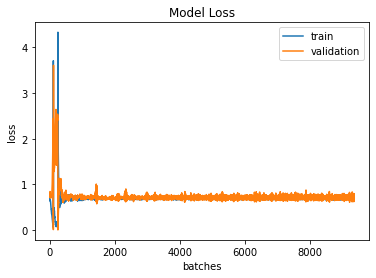

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(loss_discriminator_list)
plt.plot(loss_generator_list)
plt.title("Model Loss")
plt.ylabel("loss")
plt.xlabel("batches")
plt.legend(["train", "validation"], loc="upper right")
plt.show()
plt.savefig("plot.png")